# Experimental Noise Features

* *Author*: Christopher J. Wood (cjwood@us.ibm.com)
* *Last Updated*: December 10, 2018

This notebook shows how to use some experimental noise features. These are experimental as they are not officially supported through the Qiskit-Terra API yet and involve manually editing a compiled qobj. As such they may change or break in future releases.

In [1]:
import numpy as np

# Import Terra
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

# Import Aer backends
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import amplitude_damping_error
from qiskit_aer.utils import qobj_utils
from qiskit_aer.utils.qobj_utils import qobj_get_item_positions
from qiskit_aer.utils.qobj_utils import qobj_insert_item
from qiskit_aer.utils.qobj_utils import qobj_unitary_item

## Adding noise to a custom unitary gate

In this example we show how to add a noise model based on a custom unitary gate. For our example we will add noise on an iSWAP gate which is defined as follows:

In [2]:
ISWAP = np.array([[1, 0, 0, 0],
                  [0, 0, 1j, 0],
                  [0, 1j, 0, 0],
                  [0, 0, 0, 1]])

### CNOT circuit in terms of iSWAP gates

Our test circuit will be the decomposition of a Controlled-NOT gate in terms of two iSWAP gates and single qubit rotations. The circuit is given as follows where we have placed barrier objects where the iSWAP gate should be

In [3]:
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
cx_circ = QuantumCircuit(qr, cr)

# CNOT Circuit where iSWAP gates should be inserted at barrier locations
cx_circ.sdg(qr[1])
cx_circ.h(qr[1])
cx_circ.sdg(qr[0])
cx_circ.barrier(qr)  # Place iSWAP here
cx_circ.sdg(qr[0])
cx_circ.h(qr[0])
cx_circ.sdg(qr[0])
cx_circ.barrier(qr)  # Place iSWAP here
cx_circ.s(qr[1])

print("NOTE: iSWAP gates should be inserted at barrier positions")
print(cx_circ)

NOTE: iSWAP gates should be inserted at barrier positions
         ┌─────┐┌───┐        ░                     ░ ┌───┐
qr_1: |0>┤ Sdg ├┤ H ├────────░─────────────────────░─┤ S ├
         └─────┘└───┘┌─────┐ ░ ┌─────┐┌───┐┌─────┐ ░ └───┘
qr_0: |0>────────────┤ Sdg ├─░─┤ Sdg ├┤ H ├┤ Sdg ├─░──────
                     └─────┘ ░ └─────┘└───┘└─────┘ ░      
 cr_1: 0 ═════════════════════════════════════════════════
                                                          
 cr_0: 0 ═════════════════════════════════════════════════
                                                          


We write a helper function using the experimental `qobj_utils` module to insert iSWAP gates after barrier operations. The label string for this unitary is given as `"iswap"` which can be used later for assigning a noise model to this gate

In [4]:
def add_iswap_after_barrier(qobj):
    item = qobj_unitary_item(ISWAP, [0, 1], 'iswap')
    for pos in sorted(qobj_get_item_positions(qobj, 0, 'barrier'), reverse=True):
        qobj_insert_item(qobj, 0, item, pos)
    return qobj

simulator = Aer.get_backend('unitary_simulator')
qobj = qiskit.compile(cx_circ, simulator, shots=1)
qobj = add_iswap_after_barrier(qobj)

### Verifying circuit on the Aer unitary simulator

Next we will execute the circuit on the Aer unitary simulator to verify our qobj implements a Controlled-NOT gate in the ideal (no noise) case

In [5]:
simulator = Aer.get_backend('unitary_simulator')
result = simulator.run(qobj).result()
unitary = result.get_unitary(cx_circ).round(5)
print("Circuit unitary:")
print(unitary)

Circuit unitary:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


### Bell state preparation circuit in terms of iSWAP gate

Now we will use our iSWAP CNOT circuit to prepare an entangled state

In [6]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(qr, cr)
bell_circ.h(qr[0])
bell_circ = bell_circ + cx_circ 
bell_circ.measure(qr, cr)
print("Bell preparation circuit: iSWAPS should be inserted at barrier positions")
print(bell_circ)

Bell preparation circuit: iSWAPS should be inserted at barrier positions
         ┌─────┐┌───┐             ░                     ░    ┌───┐┌─┐
qr_1: |0>┤ Sdg ├┤ H ├─────────────░─────────────────────░────┤ S ├┤M├
         └─────┘└───┘┌───┐┌─────┐ ░ ┌─────┐┌───┐┌─────┐ ░ ┌─┐└───┘└╥┘
qr_0: |0>────────────┤ H ├┤ Sdg ├─░─┤ Sdg ├┤ H ├┤ Sdg ├─░─┤M├──────╫─
                     └───┘└─────┘ ░ └─────┘└───┘└─────┘ ░ └╥┘      ║ 
 cr_1: 0 ══════════════════════════════════════════════════╬═══════╩═
                                                           ║         
 cr_0: 0 ══════════════════════════════════════════════════╩═════════
                                                                     


Again we must add iSWAP gates back into the compiled qobj for execution on the Aer Qasm simulator

In [7]:
# Add iSWAP to compiled qobj
simulator = Aer.get_backend('qasm_simulator')
qobj = qiskit.compile(bell_circ, simulator, shots=1000)
qobj = add_iswap_after_barrier(qobj)

### Ideal output

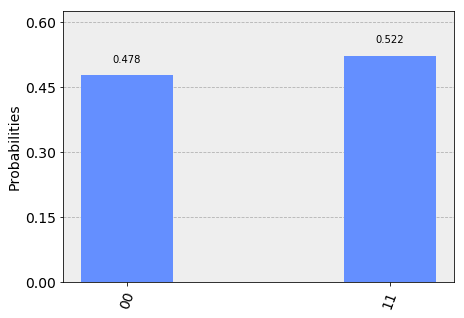

In [8]:
# Ideal circuit execution
result = simulator.run(qobj).result()
counts = result.get_counts(bell_circ)
plot_histogram(counts)

## Adding noise to a custom gate

Next we will add a noise model to the iSWAP gate using its string label `"iswap"`. We add an error term consisting of single qubit amplitude damping channels with different parameters on each of the two qubits participating in the iSWAP gate

In [9]:
# Two-qubit amplitude damping error parameters
param_iswap_q0 = 0.05
param_iswap_q1 = 0.1
p_state1 = 0.03

# Construct the error
err_q0 = amplitude_damping_error(param_iswap_q0, excited_state_population=p_state1)
err_q1 = amplitude_damping_error(param_iswap_q1, excited_state_population=p_state1)
iswap_error = err_q1.kron(err_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')

### Noisy circuit execution

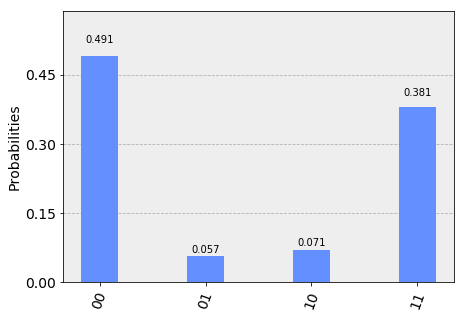

In [10]:
result_noise = simulator.run(qobj, noise_model=noise_model).result()
counts_noise = result_noise.get_counts(bell_circ)
plot_histogram(counts_noise)